In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np
from sklearn.impute import SimpleImputer

# Step 1: Load the dataset
dataset = pd.read_csv('/content/SeoulBikeData.csv', encoding='ISO-8859-1')

In [12]:
# Step 2: Inspect the dataset
print("Dataset Overview:\n", dataset.head())
print("\nNumber of features:", dataset.shape[1])
print("Number of data points:", dataset.shape[0])
print("\nFeature types:\n", dataset.dtypes)

Dataset Overview:
          Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  01/12/2017                254     0             -5.2           37   
1  01/12/2017                204     1             -5.5           38   
2  01/12/2017                173     2             -6.0           39   
3  01/12/2017                107     3             -6.2           40   
4  01/12/2017                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Win

In [13]:
# Introduce random missing values in some columns
np.random.seed(42)  # For reproducibility
cols_to_alter = ['Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)']

# Apply NaN to 10% of the rows in the specified columns
for col in cols_to_alter:
    dataset.loc[dataset.sample(frac=0.1).index, col] = np.nan

#Preprocess the dataset
# (convert to datetime and extract components)
if 'Date' in dataset.columns:
    dataset['Date'] = pd.to_datetime(dataset['Date'], format='%d/%m/%Y')
    dataset['Year'] = dataset['Date'].dt.year
    dataset['Month'] = dataset['Date'].dt.month
    dataset['Day'] = dataset['Date'].dt.day
    dataset.drop('Date', axis=1, inplace=True)  # Drop the original Date column

# Encode categorical features
categorical_columns = dataset.select_dtypes(include=['object']).columns
print("\nCategorical columns:", categorical_columns)
for col in categorical_columns:
    label_encoder = LabelEncoder()
    dataset[col] = label_encoder.fit_transform(dataset[col])

# Check for missing values
print("\nMissing values:\n", dataset.isnull().sum())


Categorical columns: Index(['Seasons', 'Holiday', 'Functioning Day'], dtype='object')

Missing values:
 Rented Bike Count              0
Hour                           0
Temperature(°C)              876
Humidity(%)                  876
Wind speed (m/s)             876
Visibility (10m)               0
Dew point temperature(°C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                   0
Snowfall (cm)                  0
Seasons                        0
Holiday                        0
Functioning Day                0
Year                           0
Month                          0
Day                            0
dtype: int64


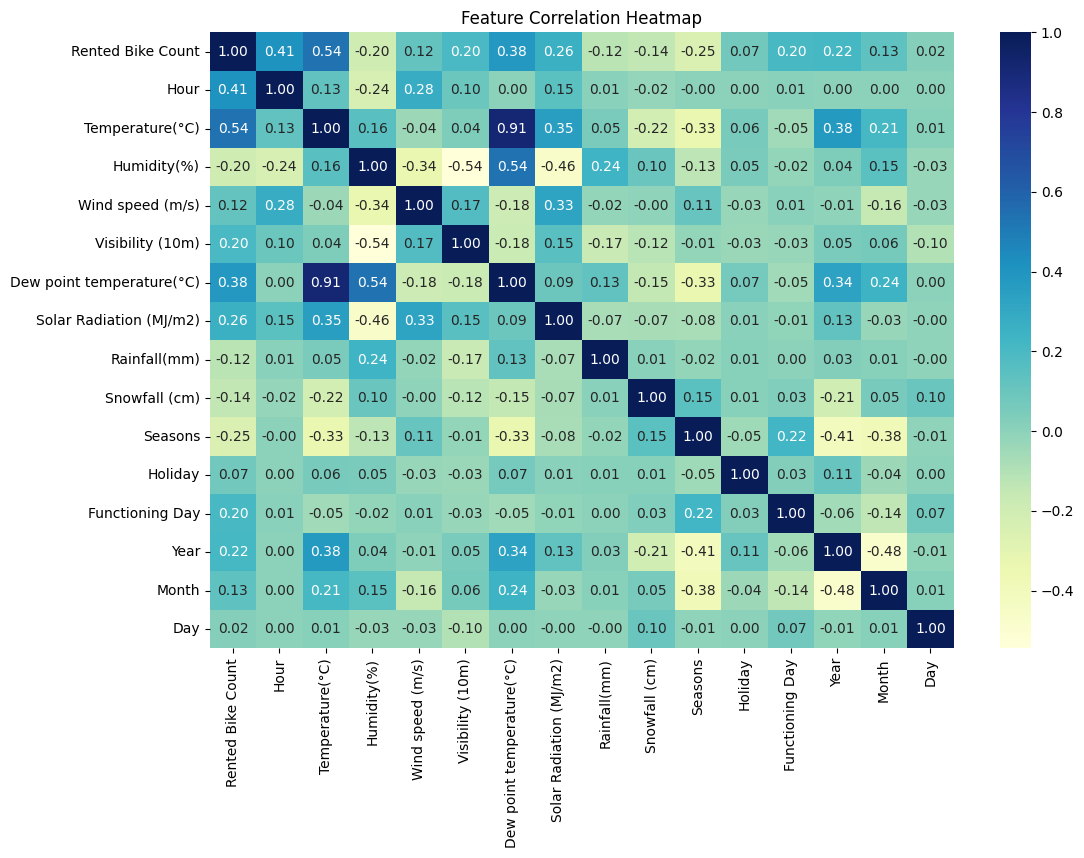

In [14]:
#Visualize Correlation
correlation_matrix = dataset.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

In [15]:
# Feature Scaling
scaler = MinMaxScaler()
numeric_features = dataset.select_dtypes(include=['int64', 'float64']).columns
input_features = numeric_features.drop('Rented Bike Count', errors='ignore')
dataset[input_features] = scaler.fit_transform(dataset[input_features])

In [16]:
# Split dataset
X = dataset.drop('Rented Bike Count', axis=1)
y = dataset['Rented Bike Count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Train and Test Models
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

Decision Tree - MAE: 185.41, RMSE: 322.73, R^2: 0.76
Linear Regression - MAE: 330.54, RMSE: 447.22, R^2: 0.54
Random Forest - MAE: 144.83, RMSE: 237.05, R^2: 0.87


<ipython-input-17-745703a235bf>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=r2_scores, palette='viridis')


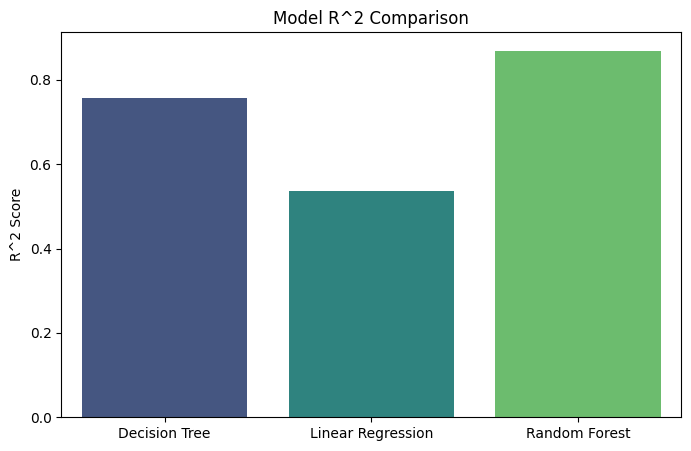

In [17]:
# Decision Tree
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Step 9: Evaluate Models
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R^2: {r2:.2f}")
    return mae, rmse, r2

# Evaluate all models
dt_metrics = evaluate_model("Decision Tree", y_test, dt_predictions)
lr_metrics = evaluate_model("Linear Regression", y_test, lr_predictions)
rf_metrics = evaluate_model("Random Forest", y_test, rf_predictions)

# Step 10: Visualize Model Performance
models = ['Decision Tree', 'Linear Regression', 'Random Forest']
r2_scores = [dt_metrics[2], lr_metrics[2], rf_metrics[2]]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=r2_scores, palette='viridis')
plt.title('Model R^2 Comparison')
plt.ylabel('R^2 Score')
plt.show()
